# Introduction

In this notebook, we shall be using Siamese Network in order to build a model to perform the task of face verification for a given character.

The paper referred to for performing this experiment is [linked here](https://proceedings.neurips.cc/paper/1993/file/288cc0ff022877bd3df94bc9360b9c5d-Paper.pdf).

In [1]:
from siameseDataset import *
from loss_func import *
from siameseModel import *
import torch
from torch import nn as nn
import pandas as pd
torch.autograd.set_detect_anomaly(True)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_path = "/home/vinayak/cleaned_anime_faces"
model_save_path = "/home/vinayak/anime_face_recognition/resources/enet_model.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
partition = {}
split_info = pd.read_csv(f"/home/vinayak/anime_face_recognition/resources/data.csv")
partition["train"] = list(split_info[split_info.label == "train"].images)
random.shuffle(partition["train"])
partition["validation"] = list(split_info[split_info.label == "valid"].images)

In [4]:
# https://omoindrot.github.io/triplet-loss#strategies-in-online-mining

In [5]:
# Create a training dataset and use it to create a training_generator
training_set = siameseDataset(partition['train'])
training_generator = torch.utils.data.DataLoader(training_set, batch_size = 1)
# training_set.show_sample()

In [6]:
# Create a training dataset and use it to create a validation_generator
validation_set = siameseDataset(partition['validation'], dtype = "validation")
validation_generator = torch.utils.data.DataLoader(validation_set, batch_size = 1)
# validation_set.show_sample()

In [7]:
# Create the model and move it to appropriate device (i.e. cuda if gpu is available)
model = enet_model().to(DEVICE)

In [8]:
# Define the loss function to be used for training
loss_func = batchHardTripletLoss(margin = 0.2).to(DEVICE)

In [9]:
# Define a learning rate and create an optimizer for training the model 
# (Adam with default momentum should be good)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Define a learning rate scheduler so that you reduce the learning rate
# As you progress across multiple epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.8)

In [10]:
# Training Loop
train_losses = []
valid_losses = []

n_epochs = 25
n_train_batches = len(training_generator)
n_valid_batches = len(validation_generator)
PRINT_PROGRESS = 30

round_off = lambda x: round(x, 5)

# Loop over number of epochs
for epch in range(n_epochs):
    
    print(f"Epoch {(epch + 1):<4}")
    # Initialize the loss values to zero at the beginning of the epoch
    train_loss = 0.
    valid_loss = 0.

    # Train for an epoch
    for idx, (images, labels) in enumerate(training_generator, start = 1):
        images, labels = images[0].to(DEVICE), labels.to(DEVICE)
        feature_vectors = model(images)
        loss = loss_func(feature_vectors, labels)
        loss.backward()
        optimizer.step()
        
        batch_loss = round_off(loss.item())
        train_loss += batch_loss
        
        if (idx % PRINT_PROGRESS == 0) or (idx == 1) or (idx == n_train_batches):
            print(f"Batch Number: {idx:<2}| Current Batch Loss: {batch_loss:<7}| Average Train Loss: {round_off(train_loss / idx):<7}")
    
    # Validate after the trained epoch
    for images, labels in validation_generator:
        images, labels = images[0].to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            feature_vectors = model(images)
            loss = loss_func(feature_vectors, labels)
            valid_loss += round_off(loss.item())
    
    # Reset the states of training and validation sets
    validation_set.characters_selected = {k:0 for k in validation_set.classes}
    validation_set.images_selected = {k:False for k in validation_set.images}
    
    training_set.characters_selected = {k:0 for k in training_set.classes}
    training_set.images_selected = {k:False for k in training_set.images}
    
    # Average the train and valid losses across all batches and save it to our array
    train_loss = round_off(train_loss / n_train_batches)
    valid_loss = round_off(valid_loss / n_valid_batches)
    
    print("".join(["-"]*75))
    print(f"Summary for Epoch {(epch + 1):<2} --->  Train Loss: {train_loss:<7}  --->  Valid Loss: {valid_loss:<7}")
    print()
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Check the valid loss and reduce learning rate as per the need
    scheduler.step()

Epoch 1   
Batch Number: 1 | Current Batch Loss: 1.73517| Average Train Loss: 1.73517
Batch Number: 30| Current Batch Loss: 0.78829| Average Train Loss: 1.25657
Batch Number: 60| Current Batch Loss: 0.6211 | Average Train Loss: 1.01586
---------------------------------------------------------------------------
Summary for Epoch 1  --->  Train Loss: 1.01586  --->  Valid Loss: 0.49077

Epoch 2   
Batch Number: 1 | Current Batch Loss: 0.39206| Average Train Loss: 0.39206
Batch Number: 30| Current Batch Loss: 0.43559| Average Train Loss: 0.45994
Batch Number: 60| Current Batch Loss: 0.1999 | Average Train Loss: 0.43082
---------------------------------------------------------------------------
Summary for Epoch 2  --->  Train Loss: 0.43082  --->  Valid Loss: 0.35034

Epoch 3   
Batch Number: 1 | Current Batch Loss: 0.25044| Average Train Loss: 0.25044
Batch Number: 30| Current Batch Loss: 0.39115| Average Train Loss: 0.30122
Batch Number: 60| Current Batch Loss: 0.31324| Average Train Loss

Batch Number: 30| Current Batch Loss: 0.0    | Average Train Loss: 0.05054
Batch Number: 60| Current Batch Loss: 0.04469| Average Train Loss: 0.04775
---------------------------------------------------------------------------
Summary for Epoch 22 --->  Train Loss: 0.04775  --->  Valid Loss: 0.12835

Epoch 23  
Batch Number: 1 | Current Batch Loss: 0.01458| Average Train Loss: 0.01458
Batch Number: 30| Current Batch Loss: 0.0    | Average Train Loss: 0.05446
Batch Number: 60| Current Batch Loss: 0.0    | Average Train Loss: 0.03851
---------------------------------------------------------------------------
Summary for Epoch 23 --->  Train Loss: 0.03851  --->  Valid Loss: 0.10711

Epoch 24  
Batch Number: 1 | Current Batch Loss: 0.0    | Average Train Loss: 0.0    
Batch Number: 30| Current Batch Loss: 0.0    | Average Train Loss: 0.0424 
Batch Number: 60| Current Batch Loss: 0.08148| Average Train Loss: 0.04298
---------------------------------------------------------------------------


In [12]:
# Save the losses to a loss_history.csv file on the disk
history = pd.DataFrame({"train_loss": train_losses, "valid_loss":valid_losses})
history.to_csv("loss_history.csv", index = False)

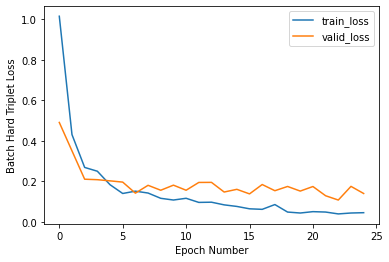

In [18]:
# Plot the loss curve obtained when training
ax = history.plot();
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Batch Hard Triplet Loss");

In [13]:
# Save the trained model to our disk
torch.save(model.state_dict(), model_save_path)

In [14]:
# Look at the progresion of learning rates
scheduler.state_dict()

{'step_size': 3,
 'gamma': 0.8,
 'base_lrs': [0.0001],
 'last_epoch': 25,
 '_step_count': 26,
 '_get_lr_called_within_step': False,
 '_last_lr': [1.677721600000001e-05]}